# Building a Neural Network

Ben H - March 2021

## Starting from the Bottom

We start by creating the most simple neural network (NN), in order to do this we are going to require some linear algebra packages - numpy and pandas, and we bring along plotly for graphing.

In [1]:
import numpy as np
import pandas as pd
import random
import plotly.graph_objects as go

random.seed(5)

Neural networks are built up of the following:

- An input layer
- A set of hidden layers
- A set of weights
- A set of biases
- An activation function, originally the Sigmoid function however now ReLU is more commonly used
- An output layer

We're going to build a very simple neural network like the original versions - with 1 hidden layer, and the Sigmoid function, which will look like the following:

![A simple neural network, by James Loy](https://miro.medium.com/max/500/1*sX6T0Y4aa3ARh7IBS_sdqw.png)

We start by defining the functions we'll be considering:

In [2]:
## Which we define as such:
def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))     # Define sigmoid function
    sig = np.minimum(sig, 0.9999)  # Set upper bound
    sig = np.maximum(sig, 0.0001)  # Set lower bound
    return sig

def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

def ReLU(x):
    return np.maximum(0,x)

def loss_value(y,y_hat):
    return ((y_hat-y)**2).sum()

We can plot these graphs between -5 and 5 to see what they look like:

In [17]:
## The sigmoid function
x = np.linspace(-5,5,1500)
y = sigmoid(x)
z = ReLU(x)

fig0 = go.Figure()

## Adding the Sigmoid
fig0.add_trace(go.Scatter(x=x,
                          y=y,
                          mode='lines',
                          name='Sigmoid'))

## Adding ReLU
fig0.add_trace(go.Scatter(x=x,
                          y=z,
                          mode='lines',
                          name='ReLU'))

fig0.update_traces(hoverinfo='text+name+y')

fig0.update_layout(title = 'Sigmoid vs ReLU',
                   yaxis_range=[-1,2],
                   xaxis_range=[-5,5],
                   xaxis_title="X",
                   yaxis_title="Y",)

fig0

We now begin by creating a neural network class, that will handle the main functions we will be dealing with.

In [4]:
class NeuralNetwork:
    def __init__(self,x,y,layer_sizes,learning_rate):
        self.input = x
        self.layer_size = layer_sizes
        self.learning_rate = learning_rate
        self.weights1 = np.random.rand(self.input.shape[1],self.layer_size)
        self.weights2 = np.random.rand(self.layer_size,1)
        self.y = y
        self.output = np.zeros(y.shape)
    
    ## neural networks work by initially passing through the hidden layer to the output, which we do here:         
    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.output = sigmoid(np.dot(self.layer1, self.weights2))
    
    ## we then look check our output value against the actual value and adjust the weights accordingly
    ## we include a learning rate here as to not overshoot the minima
    def backprop(self):
        ## we calculate the derivatives of the loss function w.r.t the weights
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1)))
        
        ## we then use the gradient to update the weights so we move closer to a local or global minimum
        self.weights1 += +d_weights1*self.learning_rate
        self.weights2 += +d_weights2*self.learning_rate

## Using the Neural Network

The NN is now ready for use. To take it for a spin we test it on the Boston data set!

In [5]:
from sklearn.datasets import load_boston
## although we're building our own NN, we still borrow some tools for SKL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Loading the data

We pull out the columns and make a dataframe from the data set:

In [46]:
## Here we have the boston data split into data and targets
boston = load_boston()

## This pulls out the data from the dataset
df = pd.DataFrame(data=boston['data'],columns=boston['feature_names'])
## This pulls out the target data from the dataset
df['MEDV']=boston['target']
## This joins them into one DataFrame

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Splitting the data into test and train sets

We next split our data into test and training sets with a 75/25 split, using our dev set as our test set for this example.

In [47]:
X = df.drop('MEDV',axis=1).values
y = df[['MEDV']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 15)

### Scaling the data

We next scale our data, as gradient descent prefers data on the same scale.

In [48]:
## We now scale the data so we can use GradientDescent
## We fit the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)

scaled_X = scaler.transform(X_train)

scaled_X[0:3]

array([[1.70023833e-02, 0.00000000e+00, 7.00879765e-01, 1.00000000e+00,
        4.52674897e-01, 9.32223083e-01, 9.37178167e-01, 9.32708494e-02,
        1.73913043e-01, 4.12213740e-01, 2.23404255e-01, 9.78573964e-01,
        4.38741722e-02],
       [3.28054843e-03, 0.00000000e+00, 2.10410557e-01, 0.00000000e+00,
        2.44855967e-01, 7.98799380e-01, 1.45211123e-01, 2.03658037e-01,
        3.04347826e-01, 2.29007634e-01, 5.10638298e-01, 9.50834221e-01,
        6.04304636e-02],
       [4.97584126e-04, 0.00000000e+00, 1.47727273e-01, 0.00000000e+00,
        1.31687243e-01, 5.47637490e-01, 4.64469619e-01, 3.31443651e-01,
        8.69565217e-02, 1.14503817e-01, 6.27659574e-01, 1.00000000e+00,
        2.17715232e-01]])

We scale our training set first, and then scale the test set using the factors from the training set - this stops our training data indirectly knowing about the structure of the test set.

In [49]:
scaled_X_test = scaler.transform(X_test)

scaled_X_test[0:3]

array([[3.26514996e-04, 3.40000000e-01, 2.06378299e-01, 0.00000000e+00,
        9.87654321e-02, 5.86560806e-01, 3.86199794e-01, 3.96260066e-01,
        2.60869565e-01, 2.70992366e-01, 3.72340426e-01, 9.97084031e-01,
        2.14403974e-01],
       [5.77521291e-03, 2.00000000e-01, 1.28665689e-01, 0.00000000e+00,
        5.39094650e-01, 9.36676995e-01, 9.12461380e-01, 1.04781837e-01,
        1.73913043e-01, 1.46946565e-01, 4.25531915e-02, 9.74542320e-01,
        1.15342163e-01],
       [1.49286478e-03, 0.00000000e+00, 1.31598240e-01, 0.00000000e+00,
        2.57201646e-01, 3.89426801e-01, 8.81565396e-01, 1.32772192e-01,
        1.73913043e-01, 2.08015267e-01, 4.25531915e-01, 1.00000000e+00,
        3.57615894e-01]])

As our neural net doesn't have any optimisers or smart initialisations, we also scale our y value too.

In [54]:
y_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler.fit(y_train)

scaled_y = y_scaler.transform(y_train)
scaled_y_test = y_scaler.transform(y_test)

And finally we run the NN, doing 1500 iterations of the loop to tune the weights:

In [55]:
nn = NeuralNetwork(scaled_X,scaled_y,4,0.01)

loss_values = []

for i in range(1500):
    nn.feedforward()
    nn.backprop()
    loss = loss_value(nn.output,nn.y)
    loss_values.append(loss)

We plot the loss function to visualise its improvements over the epochs:

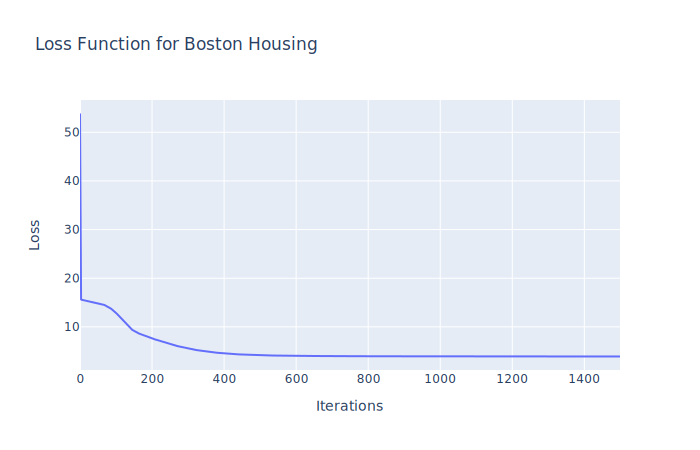

In [56]:
## Plotting the loss function
fig1 = go.Figure()

fig1.add_trace(go.Scatter(y=loss_values,
                          mode='lines'))

fig1.update_layout(title = 'Loss Function for Boston Housing',
                   xaxis_title="Iterations",
                   yaxis_title="Loss",)

We now unscale our data and check the MSE for it. 23.9 isn't terrible but we could definitely do better!

In [57]:
pred_a = sigmoid(np.dot(scaled_X_test, nn.weights1)) ## pushing our test values through the network
pred_b = sigmoid(np.dot(pred_a, nn.weights2))

predictions = y_scaler.inverse_transform(pred_b)
y_test_true = y_test

mean_squared_error(predictions,y_test_true)

23.919322973672855

The graphical comparison between the two show that we weren't far off, even with the most simple model there is!

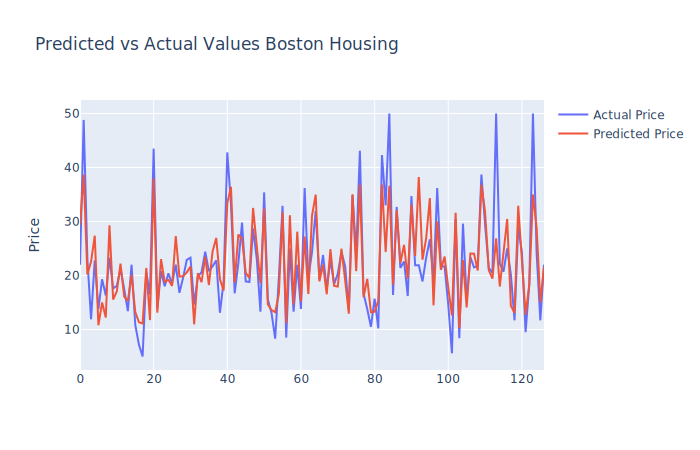

In [58]:
## combining the arrays
pdf = pd.DataFrame(data=predictions,columns=['Preds'])
pdf['True'] = y_test_true

## plotting the outputs
fig2 = go.Figure()

fig2.add_trace(go.Scatter(y=pdf['True'], mode='lines',name='Actual Price'))

fig2.add_trace(go.Scatter(y=pdf['Preds'], mode='lines',name='Predicted Price'))

fig2.update_layout(title = 'Predicted vs Actual Values Boston Housing',
                   xaxis_title="",
                   yaxis_title="Price",)

## Using Keras to create an _actual_ NN

Keras is interface for TensorFlow, and allows us to create neural networks in a far easier way than above. The inital model we made used a hidden layers with 4 nodes, we use Keras to create 3 hidden layers with a 8-24-8 set up.

In [59]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

In [60]:
#build our model
model = Sequential()

## adding layers to the model, this includes the output later
model.add(Dense(8, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

## training the model
model.fit(scaled_X,scaled_y,epochs=1500,shuffle=True,verbose=0)

## inference
prediction = model.predict(scaled_X_test)
y_0 = prediction[0][0]

y_0

0.4693547

As before we unscale our data and check the MSE!

In [61]:
predictions_keras = y_scaler.inverse_transform(prediction)
y_test_true_keras = y_test

mean_squared_error(predictions_keras,y_test_true_keras)

19.1324716711193

The is a noticeable improvement, without any hyperparameter tuning! We plot the differences between the predicted and actual values below:

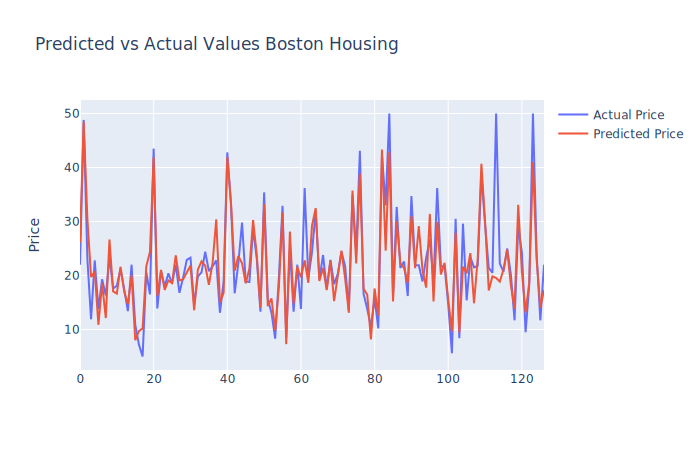

In [62]:
## combining the arrays
pdf_keras = pd.DataFrame(data=predictions_keras,columns=['Preds'])
pdf_keras['True'] = y_test_true_keras

## plotting the outputs
fig2 = go.Figure()

fig2.add_trace(go.Scatter(y=pdf_keras['True'], mode='lines',name='Actual Price'))

fig2.add_trace(go.Scatter(y=pdf_keras['Preds'], mode='lines',name='Predicted Price'))

fig2.update_layout(title = 'Predicted vs Actual Values Boston Housing',
                   xaxis_title="",
                   yaxis_title="Price",)

This is far better than the one I built, which makes sense as the model is a lot more complex!

In [18]:
import plotly.io as pio
pio.renderers.default = "svg"